# Appendix B:  The meaning of alpha in RFT vs. FDR

This Appendix will consider the meaning of $\alpha$ in the context of the random field theory (RFT) and false discovery rate (FDR) approaches to statistical inference. As in Appendix A, a one-sample test will be used.

___

### Preliminaries

Let's first import the necessary packages.

In [1]:
import numpy as np
import scipy.stats
from matplotlib import pyplot
import spm1d
import fdr1d

Next let's repeat the example from Appendix A (a one-sample dataset) using the **fdr1d** pacakge. Note that **fdr1d.inference** function returns the critical threshold.

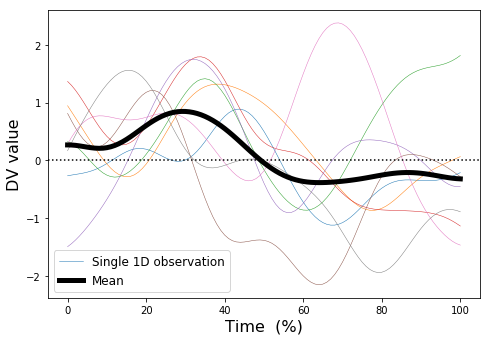

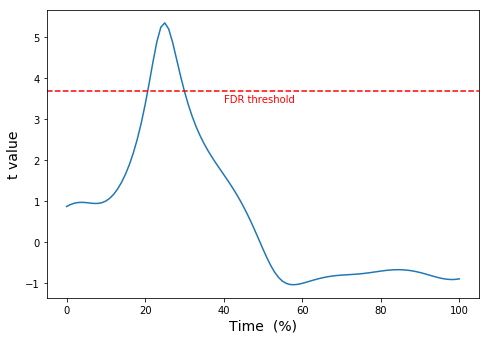

In [2]:
# generate random data and compute t statistic:
np.random.seed(246)
J,Q,W     = 8, 101, 20  #sample size, num. continuum nodes, smoothness
alpha     = 0.05        #Type I error rate
df        = J - 1       #degrees of freedom
y         = spm1d.rft1d.randn1d(J, Q, W, pad=True)   #a random 1D sample
t         = y.mean(axis=0) / (  y.std(ddof=1, axis=0)/ (J**0.5)  )  #1D test statistic

# critical threshold:
tstar_fdr = fdr1d.inference(t, df, alpha=alpha, stat='T')


# plot 1D data with mean:
pyplot.figure()
ax   = pyplot.axes([0, 0, 1, 1])
h0   = ax.plot(y.T, linewidth=0.5)[0]
h1   = ax.plot(y.mean(axis=0), linewidth=5, color='k')[0]
ax.axhline(0, color='k', linestyle=':')
ax.legend([h0,h1], ['Single 1D observation', 'Mean'], fontsize=12)
ax.set_xlabel('Time  (%)', size=16)
ax.set_ylabel('DV value', size=16);
pyplot.show()


# plot 1D t statistic and critical threshold:
pyplot.close('all')
ax = pyplot.axes([0,0,1,1])
ax.plot(t)
ax.axhline(tstar_fdr, linestyle='--', color='r')
ax.text(40, 3.4, 'FDR threshold', color='r')
ax.set_xlabel('Time  (%)', size=14)
ax.set_ylabel('t value', size=14)
pyplot.show()

Last let's compare the RFT threshold to the FDR threshold for this dataset.

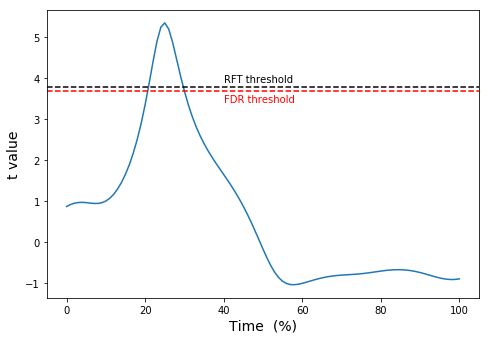

In [3]:
# RFT threshold:
tstar_rft = spm1d.rft1d.t.isf(alpha, df, Q, W)

# plot 1D t statistic and critical thresholds:
pyplot.close('all')
ax = pyplot.axes([0,0,1,1])
ax.plot(t)
ax.axhline(tstar_rft, linestyle='--', color='k')
ax.axhline(tstar_fdr, linestyle='--', color='r')
ax.text(40, 3.9, 'RFT threshold', color='k')
ax.text(40, 3.4, 'FDR threshold', color='r')
ax.set_xlabel('Time  (%)', size=14)
ax.set_ylabel('t value', size=14)
pyplot.show()

The RFT and FDR thresholds are quite similar for this dataset, with the FDR providing a slightly lower (slightly less conservative) threshold. There is little more that we can conclude from this dataset. Simulating many different random 1D datasets is needed to clarify the differences between the RFT and FDR approaches.

___

### False positive calculations

A false positive refers to an incorrect inference of an effect when none in fact exists. The 1D random number generator that is used in the example above (**spm1d.rft1d.randn1d**) yields datasets which have a true *population mean* of zero, but due to random sampling the *sample mean* of each dataset is generally not zero, as shown in the example data above. Very large datasets (e.g. *J* = 10,000) would have _sample means_ much closer to zero.

Since the true population mean is zero, a false positive for this one-sample t test is a conclusion that the sample mean is significantly different from zero.  Thus the example above represents a false positive for both RFT and FDR.

The threshold $\alpha$=0.05 does not control for false positives in a single test, but instead controls for false positives over an infinite number of tests. We can therefore check whether false positive control is accurate by simulating a large number of tests and then counting the proportion of tests for which the null hypothesis is rejected.

Significance can be checked simply by comparing the maximum t value ($t_\textrm{max}$) to the threshold;  if $t_\textrm{max}$ is greater than the threshold, then the null is rejected.

In [4]:
false_positive_rft = t.max() > tstar_rft
false_positive_fdr = t.max() > tstar_fdr

print( false_positive_rft )
print( false_positive_fdr )

True
True


Let's now repeat this on a large number of tests. To avoid a very long simulation, we'll conduct just 1000 tests. 

False positive rates:  RFT=0.045, FDR=0.028


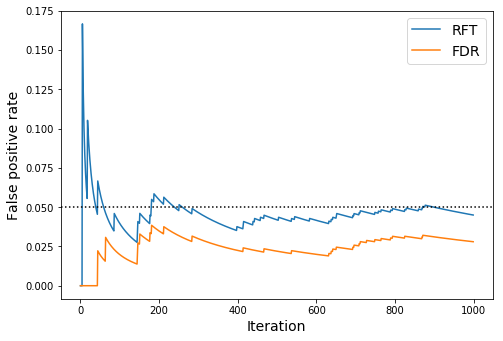

In [5]:
nIter     = 1000  #number of simulation iterations
fp_rft    = []    #false positive for RFT inference
fp_fdr    = []    #false positive for FDR inference


np.random.seed(0)
for i in range(nIter):
    y         = spm1d.rft1d.randn1d(J, Q, W, pad=True)
    t         = y.mean(axis=0) / (  y.std(ddof=1, axis=0)/ (J**0.5)  )
    tstar_fdr = fdr1d.inference(t, df, alpha=alpha, stat='T')
    if tstar_fdr is None:
        tstar_fdr = np.inf
    fp_rft.append( t.max() > tstar_rft )
    fp_fdr.append( t.max() > tstar_fdr )


# calculate overall false positive rates:
fpr_rft   = np.mean(fp_rft)
fpr_fdr   = np.mean(fp_fdr)
print('False positive rates:  RFT=%.3f, FDR=%.3f'%(fpr_rft, fpr_fdr))


# plot progression of false positive rate with an increading number of tests:
pyplot.close('all')
ax          = pyplot.axes([0,0,1,1])
fpr_cum_rft = np.cumsum(fp_rft) / np.arange(1,nIter+1) #cumulative false positive rate (RFT)
fpr_cum_fdr = np.cumsum(fp_fdr) / np.arange(1,nIter+1) #cumulative false positive rate (FDR)
ax.plot( fpr_cum_rft, label='RFT' )
ax.plot( fpr_cum_fdr, label='FDR' )
ax.axhline(0.05, color='k', linestyle=':')
ax.set_xlabel('Iteration', size=14)
ax.set_ylabel('False positive rate', size=14)
ax.legend(fontsize=14)
pyplot.show()

The RFT false positive rate fluctuates greatly for small number of iterations, and it approaches $\alpha$=0.05 as the number of simulation iterations increases. If we were to repeat this simulation using a larger number of iterations (10,000 or 100,000) we would find that RFT's simulation-based false positive rate would converge even more closely to $\alpha$=0.05.  These results suggest that RFT is valid for conducting hypothesis testing (because RFT accurately controls the long-term false positive rate at $\alpha$).

The FDR results show that the FDR false positive rate is considerably lower than the RFT false positive rate. This suggests that FDR will yield far fewer false positives than RFT.  It also implies that the FDR procedure is not accurately controlling the false positive rate.  However, FDR is not designed to control the false positive rate, it is instead designed to control the proportion of false positive *nodes* amongst all significant nodes, where a *node* is a time point. Thus, if *N* total nodes exceed the critical FDR threshold in a given iteration, 100($\alpha$)% of those nodes, or $\alpha N$ nodes, are expected to be false positives. Equivalently, under FDR control 100(1-$\alpha$)% of all suprathreshold nodes are expected to be true positives.

Unfortunately, FDR's control cannot be verified in the same way as above, because in the simulations above we assumed that the true mean was zero, and thus that there are no true positives. In order to check the validity of the FDR approach we first need to create models of true effects, so that we know how many true positives to expect. Appendix C discusses true effect models and how they relate to RFT and FDR inference. Appendix D validates FDR's control of the false positive node proportion.

___

### Summary

Interpretations of $\alpha$:
* RFT: $\alpha$ is the ___false positive rate___ over a large number of experiments
* FDR: $\alpha$ is the ___proportion of significant nodes that are false positives___ over a large number of experiments.

Interpretations of critical thresholds:
* RFT:  similarly smooth random 1D data would produce a 1D test statistic that exceeds the RFT threshold with a probability of $\alpha$
* FDR:  similarly smooth random 1D data would produce a 1D test statistic whose suprathreshold nodes contain false positive nodes at a rate of $\alpha$
* Since RFT and FDR control different features, their thresholds are generally different.

Validations:
* This Appendix validated RFT's false positive rate control for a one-sample t test. Validations for other aspects of RFT, including in different types of test, are available elsewhere (Pataky 2016).
* Appendix D validates FDR's false positive node proportion control for a one-sample t test.

### References
Pataky TC (2016). rft1d: Smooth One-Dimensional Random Field Upcrossing Probabilities in Python. Journal of Statistical Software 71(7): 1-22. http://doi.org/10.18637/jss.v071.i07
